# 다중분류 (뉴스 기사 분류 문제)
이전 섹션에서 본 예제는 벡터 입력을 받아서 두개의 클래스로 분류하는 문제였다.  
두개 이상의 클래스(종류,분류)로 나위어 질 경우 다중분류라는 방식을 사용한다.  
로이터 뉴스를 46개의 토픽으로 분류하는 예제를 통해 다중분류에 대해 확인해보자.  

## 로이터 데이터 셋
 - 1986년에 로이터에서 공개한 짧은 뉴스 기사와 토픽의 집합인 로이터 데이터셋을 사용.
 - 텍스트 분류를 위해 널리 사용되는 간단한 데이터셋이다.
 - 46개의 토픽이 있으며 어떤 토픽은 다른 것에 비해 데이터가 많다. 각 토픽은 훈련 세트에 최소한 10개의 샘플을 가지고 있다.  
 
## 데이터셋 로드

In [1]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)
len(train_data)
len(test_data)
train_data[10]

Using TensorFlow backend.


[1,
 245,
 273,
 207,
 156,
 53,
 74,
 160,
 26,
 14,
 46,
 296,
 26,
 39,
 74,
 2979,
 3554,
 14,
 46,
 4689,
 4329,
 86,
 61,
 3499,
 4795,
 14,
 61,
 451,
 4329,
 17,
 12]

## reuters 객체의 함수로 index list를 가져와보자
reuters객체의 get_word_index()함수를 통해서 dictionary타입의 word_index를 가져올 수 있다.  
word_index는 (value, key) 형태로 되어있다. 이를 key, value 형태로 바꿔보자.  

In [2]:
# word_index : (value, key), reverse_word_index : (key, value)
word_index = reuters.get_word_index()
# print('word_index: \n{0}'.format(word_index))
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# print('reverse_word_index: \n{0}'.format(reverse_word_index))
print('word_index, reverse_word_index type: {0}, {1}\n'.format(type(word_index), type(reverse_word_index)))

word_index, reverse_word_index type: <class 'dict'>, <class 'dict'>



In [3]:
'''
train_data[0]의 0, 1, 2는 '패딩', '문서 시작', '사전에 없음'을 위한 인덱스이므로 3을 뺀다.
dictionary의 get()메소드의 2번째 인자로 '?'와 같은 값을 넣어주면, 키에 대한 값이 없을 경우 '?'를 출력한다.
결국 패딩, 문서시작, 사전에 없음이 나올때마다 '?'와 같은 구분자가 출력되게 된다.
'''
for i in train_data[0]: print(i)
print('Remove padding(0,1,2), separator: ?:')
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print('{0}\n'.format(decoded_newswire))

print('Remove padding(0,1,2), separator: ##:')
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '##') for i in train_data[0]])
print('{0}\n'.format(decoded_newswire))

print('Not Remove padding, separator: ##:')
decoded_newswire = ' '.join([reverse_word_index.get(i, '##') for i in train_data[0]])
print('{0}\n'.format(decoded_newswire))

1
2
2
8
43
10
447
5
25
207
270
5
3095
111
16
369
186
90
67
7
89
5
19
102
6
19
124
15
90
67
84
22
482
26
7
48
4
49
8
864
39
209
154
6
151
6
83
11
15
22
155
11
15
7
48
9
4579
1005
504
6
258
6
272
11
15
22
134
44
11
15
16
8
197
1245
90
67
52
29
209
30
32
132
6
109
15
17
12
Remove padding(0,1,2), separator: ?:
? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3

Remove padding(0,1,2), separator: ##:
## ## ## said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental opera

## 데이터셋 준비


In [4]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 훈련 데이터 벡터 변환
x_train = vectorize_sequences(train_data)
# 테스트 데이터 벡터 변환
x_test = vectorize_sequences(test_data)

레이블을 벡터로 바꾸는 방법은 두 가지이다. 
 - 그 중 하나는 레이블의 리스트를 정수 텐서로 변환하는 것과 원-핫 인코딩을 사용하는 것이다. 
 - 원-핫 인코딩이 범주형 데이터에 널리 사용되기 때문에 범주형 인코딩이라고도 부른다.
 - 원-핫 인코딩에 대한 자세한 설명은 6.1절을 참고하자. 
 - 이 경우 레이블의 원-핫 인코딩은 각 레이블의 인덱스 자리는 1이고 나머지는 모두 0인 벡터이다.

In [5]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 훈련 레이블 벡터 변환
one_hot_train_labels = to_one_hot(train_labels)
# 테스트 레이블 벡터 변환
one_hot_test_labels = to_one_hot(test_labels)

이미 케라스에는 이를 위한 내장 함수가 있다.

In [6]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## 모델 구성
### 클래스의 갯수 증가.. 출력공간의 차원의 증가( 2 -> 46 )
이 토픽 분류 문제는 이전의 영화 리뷰 분류처럼 두 경우 모두 짧은 텍스트를 분류하는 것이다.  
여기에서는 새로운 제약 사항이 추가되었다. 바로 출력 클래스의 개수가 2에서 46개로 늘어난 점이다.  
그래서 출력 공간의 차원이 훨씬 커졌다.

### 출력공간 차원의 증가로 중간층의 차원의 변경이 필요하다..(정보의 누락, 병목현상을 피하기 위해)
이전에 사용했던 것처럼 Dense 층을 쌓으면 각 층은 이전 층의 출력에서 제공한 정보만 사용할 수 있다.  
한 층이 분류 문제에 필요한 일부 정보를 누락하면 그 다음 층에서 이를 복원할 방법이 없다.  
각 층은 잠재적으로 정보의 병목이 될 수 있다. 이전 예제에서 16차원을 가진 중간층을 사용했지만 16차원 공간은 46개의 클래스를 구분하기에 부족하고 이렇게 규모가 작은 층은 유용한 정보를 완전히 잃게 되는, 정보의 병목 지점처럼 동작할 수 있다.

이런 이유로 좀 더 규모가 큰 층을 사용하자. 64개의 유닛을 사용해 보자

In [7]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

이 구조에서 주목해야 할 점이 두 가지 있다:
  
- 마지막 Dense 층의 크기가 46이다. 각 입력 샘플에 대해서 46차원의 벡터를 출력한다는 뜻이다. 이 벡터의 각 원소(각 차원)은 각기 다른 출력 클래스가 인코딩된 것이다.  
- 마지막 층에 softmax 활성화 함수가 사용되었다. 각 입력 샘플마다 46개의 출력 클래스에 대한 확률 분포를 출력합니다. 즉, 46차원의 출력 벡터를 만들며 output[i]는 어떤 샘플이 클래스 i에 속할 확률이다. 46개의 값을 모두 더하면 1이 된다.
  
이런 문제에 사용할 최선의 손실 함수는 categorical_crossentropy이다. 이 함수는 두 확률 분포의 사이의 거리를 측정한다. 여기에서는 네트워크가 출력한 확률 분포와 진짜 레이블의 분포 사이의 거리이다. 두 분포 사이의 거리를 최소화하면 진짜 레이블에 가능한 가까운 출력을 내도록 모델을 훈련하게 된다.

In [8]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 훈련 검증
훈련 데이터에서 1,000개의 샘플을 따로 떼어서 검증 세트로 사용해보자.

In [9]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

20번의 에포크로 훈련시켜보자

In [10]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 170us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 1s 128us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 1s 128us/step - loss: 1.0953 - acc: 0.7653 - val_loss: 1.1710 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.8695 - acc: 0.8156 - val_loss: 1.0781 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.7031 - acc: 0.8480 - val_loss: 0.9846 - val_acc: 0.7820
Epoch 6/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.5663 - acc: 0.8799 - val_loss: 0.9419 - val_acc: 0.8030
Epoch 7/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.4580 - acc: 0.9045 - val_loss: 0.9099 - val_acc: 0.8020


## 손실 곡선

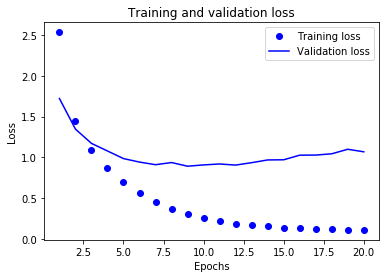

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 정확도 곡선

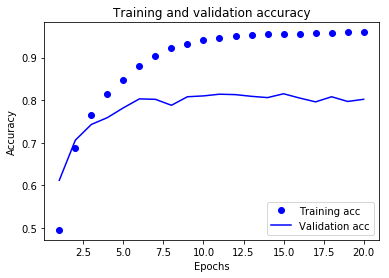

In [14]:
plt.clf()   # 그래프를 초기화합니다

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 9번째 에포크 이후로 과대적합(over-fitting)이 발생한다.
에포크를 9번으로 설정하고 다시 훈련시켜보자

In [15]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 169us/step - loss: 2.5398 - acc: 0.5226 - val_loss: 1.6733 - val_acc: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 135us/step - loss: 1.3712 - acc: 0.7121 - val_loss: 1.2758 - val_acc: 0.7210
Epoch 3/9
7982/7982 [==============================] - 1s 135us/step - loss: 1.0136 - acc: 0.7781 - val_loss: 1.1303 - val_acc: 0.7530
Epoch 4/9
7982/7982 [==============================] - 1s 132us/step - loss: 0.7976 - acc: 0.8251 - val_loss: 1.0538 - val_acc: 0.7590
Epoch 5/9
7982/7982 [==============================] - 1s 122us/step - loss: 0.6393 - acc: 0.8623 - val_loss: 0.9754 - val_acc: 0.7930
Epoch 6/9
7982/7982 [==============================] - 1s 122us/step - loss: 0.5124 - acc: 0.8921 - val_loss: 0.9103 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 1s 121us/step - loss: 0.4123 - acc: 0.9139 - val_loss: 0.8919 - val_acc: 0.8210
Epoch 8

In [16]:
results

[1.0224028317289275, 0.774265360694216]

대략 75%의 정확도를 달성했다.(mac에서 ubuntu pc로 옮겨서 실행해보니 성능이 더 좋아져서 77%까지 높아졌다)  
균형 잡힌 이진 분류 문제에서 완전히 무작위로 분류하면 50%의 정확도를 달성한다.  
이 문제는 불균형한 데이터셋을 사용하므로 무작위로 분류하면 19% 정도를 달성한다. 여기에 비하면 이 결과는 꽤 좋은 편이다:

무작위의 데이터셋을 분류한 결과는 정확도가 얼마쯤 되는지 확인해보자.

In [19]:
import copy

test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19278717720391808

무작위의 데이터셋을 분류한 결과의 정확도는 약 18%로 나온다.

## 새로운 데이터에 대해 예측해보자
모델 인스턴스의 predict 메서드는 46개 토픽에 대한 확률 분포를 반환한다. 테스트 데이터 전체에 대한 토픽을 예측해보자:

In [20]:
predictions = model.predict(x_test)
# predictions의 각 항목은 길이가 46인 벡터입니다:
print('predictions size: {0}'.format(predictions[0].shape))
# 이 벡터의 원소 합은 1입니다:
print('predictions sum: {0}'.format(np.sum(predictions[0])))
# 가장 큰 값이 예측 클래스가 됩니다. 즉, 가장 확률이 높은 클래스입니다:
print('predictions max: {0}'.format(np.argmax(predictions[0])))

predictions size: (46,)
predictions sum: 1.0
predictions max: 3


## 레이블과 손실을 다루는 다른 방법
 - 앞서 언급한 것처럼 원핫인코딩이 아닌, 레이블을 인코딩하는 다른 방법은 다음과 같이 정수 텐서로 변환하는 것이다.  
 - 이 방식을 사용하려면 손실 함수 하나만 바꾸면 된다. 지금까지 이 chapter에서 사용된 손실 함수 categorical_crossentropy는 레이블이 범주형 인코딩되어 있을 것이라고 기대한다.  
 - 정수 레이블을 사용할 때는 sparse_categorical_crossentropy를 사용해야 한다.  
 - 이 손실 함수는 인터페이스만 다를 뿐이고 수학적으로는 categorical_crossentropy와 동일합니다.

In [21]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

## 충분히 큰 중간층을 두어야 하는 이유
앞서 언급한 것처럼 마지막 출력이 46차원이기 때문에 중간층의 히든 유닛이 46개보다 많이 적어서는 안된다.  
46차원보다 훨씬 작은 중간층(예를 들면 4차원)을 두면 정보의 병목이 어떻게 나타나는지 확인해보자.  

In [22]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 183us/step - loss: 3.2660 - acc: 0.1461 - val_loss: 2.7982 - val_acc: 0.3830
Epoch 2/20
7982/7982 [==============================] - 1s 158us/step - loss: 2.2586 - acc: 0.4454 - val_loss: 1.9289 - val_acc: 0.5170
Epoch 3/20
7982/7982 [==============================] - 1s 170us/step - loss: 1.4987 - acc: 0.6391 - val_loss: 1.5101 - val_acc: 0.6190
Epoch 4/20
7982/7982 [==============================] - 1s 162us/step - loss: 1.2049 - acc: 0.6859 - val_loss: 1.4191 - val_acc: 0.6630
Epoch 5/20
7982/7982 [==============================] - 1s 164us/step - loss: 1.0508 - acc: 0.7329 - val_loss: 1.3706 - val_acc: 0.6850
Epoch 6/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.9338 - acc: 0.7766 - val_loss: 1.3617 - val_acc: 0.7080
Epoch 7/20
7982/7982 [==============================] - 1s 157us/step - loss: 0.8401 - acc: 0.8037 - val_loss: 1.3551 - val_acc: 0.7130


검증정확도가 약 77%에서 약 71%로 6%정도 낮아진 것을 볼 수 있다.
중간층의 차원이 46보다 작아서 압축을 하게 되고 여기서 손실이 발생했기 때문이다.
이를 병목현상이라고 부른다.

## 추가 실험
 - 더 크거나 작은 층을 사용해 보자: 32개 유닛, 128개 유닛 등
 - 여기에서 두 개의 은닉층을 사용했습니다. 한 개의 은닉층이나 세 개의 은닉층을 사용해 보자.

## 정리
다음은 이 예제에서 배운 것들이다.

 - N개의 클래스로 데이터 포인트를 분류하려면 네트워크의 마지막 Dense 층의 크기는 N이어야 한다.
 - 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 출력하기 위해 softmax 활성화 함수를 사용해야 한다.
 - 이런 문제에는 항상 범주형 크로스엔트로피를 사용해야 합니다. 이 함수는 모델이 출력한 확률 분포와 타깃 분포 사이의 거리를 최소화한다.
 - 다중 분류에서 레이블을 다루는 두 가지 방법이 있다.
 - 레이블을 범주형 인코딩(또는 원-핫 인코딩)으로 인코딩하고 categorical_crossentropy 손실 함수를 사용한다.
 - 레이블을 정수로 인코딩하고 sparse_categorical_crossentropy 손실 함수를 사용한다.
 - 많은 수의 범주를 분류할 때 중간층의 크기가 너무 작아 네트워크에 정보의 병목이 생기지 않도록 해야한다.